In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve

%matplotlib inline


In [259]:
data_path = "data\\train.csv"
df = pd.read_csv(data_path)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [260]:
# df.describe()

In [261]:
df.set_index("PassengerId", drop=True, inplace=True)

df_part = df.drop(columns=["Name", "Ticket", "Cabin", "Embarked", "Fare"])
df_part = df_part.dropna(axis="rows")

In [262]:
df_part.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
PassengerId,,,,,,
1,0,3,male,22.0,1,0
2,1,1,female,38.0,1,0
3,1,3,female,26.0,0,0
4,1,1,female,35.0,1,0
5,0,3,male,35.0,0,0


In [263]:
df_part["Pclass"].value_counts()

3    355
1    186
2    173
Name: Pclass, dtype: int64

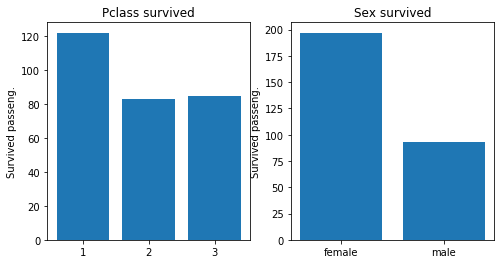

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cols_compare = ["Pclass", "Sex"]

for i, col_name in enumerate(cols_compare):
    class_survived = df_part[["Survived", col_name]].groupby(by=[col_name]).sum()
    axes[i].set_ylabel("Survived passeng.")
    axes[i].set_title(col_name +" survived")
    axes[i].bar(class_survived.index.values.astype(str), class_survived["Survived"].values) # 

plt.show()

In [265]:
# survived passengers Pclass-sex
sex_class_survived = pd.crosstab(df_part["Sex"], df_part["Pclass"], values=df_part["Survived"], aggfunc="sum")
sex_class_survived

Pclass,1,2,3
Sex,,,
female,82,68,47
male,40,15,38


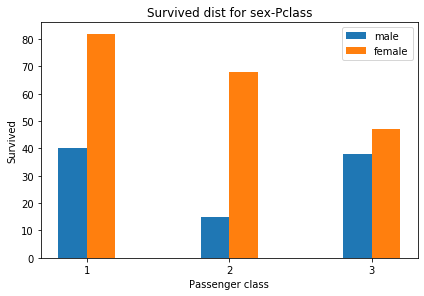

In [266]:
fig, ax = plt.subplots()
x = np.arange(sex_class_survived.columns.shape[0])

bar_width = 0.2
rects1 = ax.bar(x - bar_width/2, sex_class_survived.loc["male"].values, bar_width, label='male')
rects2 = ax.bar(x + bar_width/2, sex_class_survived.loc["female"].values, bar_width, label='female')

ax.set_xticks(x)
ax.set_xticklabels(sex_class_survived.columns)
ax.legend()
ax.set_ylabel("Survived")
ax.set_xlabel("Passenger class")

fig.tight_layout()
plt.title("Survived dist for sex-Pclass")
plt.show()

Text(0, 0.5, 'Passengers')

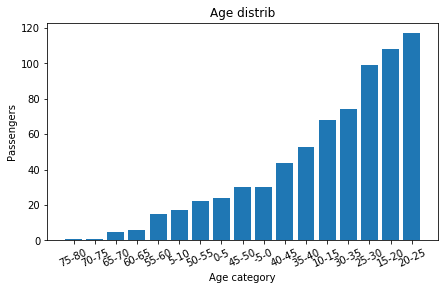

In [267]:
df_part["Age_categ"] = df_part["Age"].apply(lambda x: (x+1)//5).astype(int)
age_categ_counts = df_part["Age_categ"].value_counts().sort_values()
xtick_labels = [f"{interv[0]}-{interv[1]}" for interv in zip(age_categ_counts.index.values*5-5, age_categ_counts.index.values*5)]
plt.figure(figsize=(7,4))
plt.bar(np.arange(age_categ_counts.values.shape[0]), 
            age_categ_counts.values,
            tick_label=xtick_labels)
plt.title("Age distrib")
plt.xticks(rotation=25)
plt.xlabel("Age category")
plt.ylabel("Passengers")

In [324]:
def get_predict_with_prob(prob_array, min_prob):
    return np.where(prob_array>min_prob, 1, 0)[:, 1]

def plot_roc_auc_curve(fpr, tpr, title_start, return_res=False):
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.title(f"{title_start} AUC score: {auc_score:.5}")
    if return_res:
        return plt.plot(fpr, tpr)
    plt.plot(fpr, tpr, label="auc curve")
    plt.show()

#### Train basic logistic regression model

In [269]:
binrizer = LabelBinarizer()

In [270]:
df_part["Sex"] = binrizer.fit_transform(df_part["Sex"])

In [271]:
train_size = int(df_part.shape[0] * 0.8)
test_size = df_part.shape[0] - train_size
# shuffle data
df_part = df_part.sample(frac=1)
# Y train, test data
y_train = df_part["Survived"].head(train_size)
y_test = df_part["Survived"].tail(test_size)

# drop cols
df_part = df_part.drop(columns=["Survived", "Age"])
# X train, test data
X_train = df_part.head(train_size)
X_test = df_part.tail(test_size)

print(f"train data size: {X_train.shape[0]}, test data size: {X_test.shape[0]}")

train data size: 571, test data size: 143


In [347]:
# X_train.head()

In [272]:
# container for models
models = {}

In [273]:
log_model = LogisticRegression(n_jobs=-1)
log_model.fit(X_train, y_train)
models.update({"Log_model": {"model": log_model}})

In [276]:
# predicted_prob = log_model.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, predicted_prob[:,1], pos_label=1)
# plot_roc_auc_curve(fpr, tpr, "Basic regress.")

#### Train logistic regression with cross validation

In [277]:
log_model_cv = LogisticRegressionCV(Cs=15, n_jobs=-1).fit(X_train, y_train)
models.update({"Log_model_cv": {"model": log_model_cv}})

In [278]:
# train score
log_model_cv.score(X_train, y_train)

0.8108581436077058

In [279]:
# test score
log_model_cv.score(X_test, y_test)

0.8251748251748252

In [281]:
# log_model_cv.classes_

In [283]:
# fpr, tpr, thresholds = roc_curve(y_test, predicted_prob[:,1], pos_label=1)
# auc_score = auc(fpr, tpr)
# plot_roc_auc_curve(fpr, tpr, "Regress. with CV")
# print(f"AUC score: {auc_score}")

#### Try find best model

In [284]:
params = {"Cs": np.arange(10, 20, 2), "solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga")}
best_reg = GridSearchCV(LogisticRegressionCV(), param_grid=params, n_jobs=-1)
best_reg.fit(X_train, y_train)

C:\Users\Vadim\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                            dual=False, fit_intercept=True,
                                            intercept_scaling=1.0,
                                            l1_ratios=None, max_iter=100,
                                            multi_class='auto', n_jobs=None,
                                            penalty='l2', random_state=None,
                                            refit=True, scoring=None,
                                            solver='lbfgs', tol=0.0001,
                                            verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'Cs': array([10, 12, 14, 16, 18]),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
           

In [285]:
# pd.DataFrame(best_reg.cv_results_)
print("best params", best_reg.best_params_, ", best score", best_reg.best_score_)

best params {'Cs': 14, 'solver': 'sag'} , best score 0.8073226544622425


In [286]:
# get best model
reg_model = best_reg.best_estimator_
models.update({"Log_model_cv_best": {"model": reg_model}})

In [287]:
# predicted_prob = reg_model.predict_proba(X_test)
# plot_roc_auc_curve(fpr, tpr, "Best model. with CV")

In [288]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#### Test decision tree

In [289]:
params = {"min_samples_split": np.arange(2, 30, 4), "criterion": ("gini", "entropy")}
grid_best_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=params, n_jobs=-1)

In [290]:
grid_best_tree.fit(X_train, y_train)
grid_best_tree.best_params_

{'criterion': 'gini', 'min_samples_split': 26}

In [291]:
# get best model
tree = grid_best_tree.best_estimator_
models.update({"tree_clasif": {"model": tree}})

#### Test SGDclass

In [292]:
sgd_model = SGDClassifier(loss="log", n_jobs=-1).fit(X_train, y_train)
models.update({"sgd_clasif": {"model": sgd_model}})

In [293]:
sgd_model.score(X_test, y_test)

0.8181818181818182

#### Compare all models

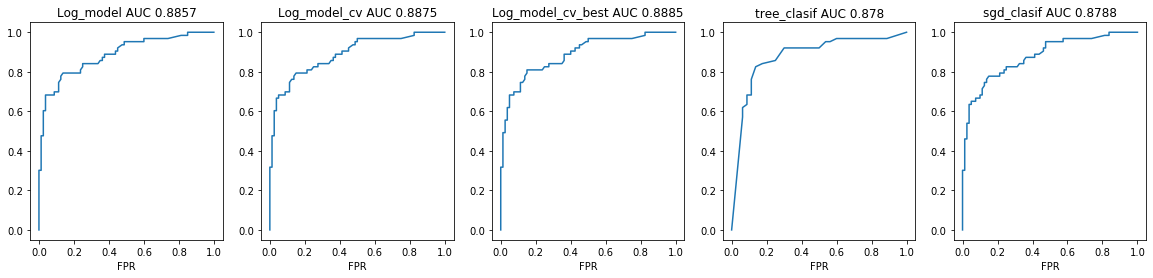

In [294]:
fig, axes = plt.subplots(1, len(models), figsize=(len(models)*4, 4))
for i, key in enumerate(models):
    score = models[key]["model"].score(X_test, y_test)
    predicted_prob = models[key]["model"].predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, predicted_prob[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    
    models[key].update({"score": score, "auc_score": auc_score})
    axes[i].set_title(f"{key} AUC {auc_score:.4}")
    axes[i].set_xlabel("FPR")
    axes[i].plot(fpr, tpr)

In [295]:
for key in models:
    print(f"Model - {key}\n\tscore: {models[key]['score']:.5}\n\tauc_score: {models[key]['auc_score']:.5}")

Model - Log_model
	score: 0.8251748251748252
	 auc_score: 0.8857142857142857
Model - Log_model_cv
	score: 0.8251748251748252
	 auc_score: 0.8875
Model - Log_model_cv_best
	score: 0.8251748251748252
	 auc_score: 0.8884920634920634
Model - tree_clasif
	score: 0.7972027972027972
	 auc_score: 0.8779761904761905
Model - sgd_clasif
	score: 0.8181818181818182
	 auc_score: 0.8787698412698413


In [325]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, plot_precision_recall_curve


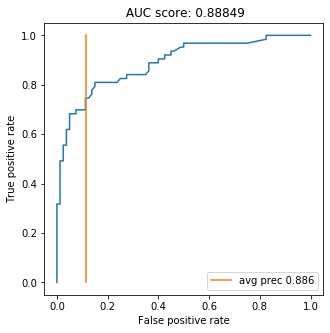

In [328]:
# test precision recall score for Log_model_cv_best
pred_proba = reg_model.predict_proba(X_test)
# precision, recall 
precision, recall, threshhold = precision_recall_curve(y_test.values, pred_proba[:, 1])

average_precision = average_precision_score(y_test, pred_proba[:, 1])
fpr, tpr, thresh = roc_curve(y_test, pred_proba[:, 1])

# try find optimal score
plot_roc_auc_curve(fpr, tpr, "", return_res=True)
plt.plot([1-average_precision, 1-average_precision], [0, 1], label=f"avg prec {average_precision:.3}")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision recall curve')

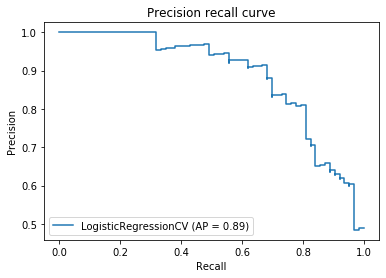

In [329]:
plot_precision_recall_curve(reg_model, X_test, y_test)
plt.title("Precision recall curve")

#### predict test data

In [331]:
test_path = "data\\test.csv"
test_df = pd.read_csv(test_path)
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [340]:
test_df["Age"].isna().sum()

0

In [342]:
# replace emty data to median value
test_df["Age"][test_df["Age"].isna()] = test_df["Age"].median()

C:\Users\Vadim\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# prepare data for predict
test_df = test_df.set_index("PassengerId")
drop_cols = ["Name", "Ticket", "Cabin", "Embarked", "Fare", "Age"]
test_df["Sex"] = binrizer.fit_transform(test_df["Sex"])

In [345]:
test_df["Age_categ"] = test_df["Age"].apply(lambda x: (x+1)//5).astype(int)
test_df = test_df.drop(columns=drop_cols)
test_df.head()

,Pclass,Sex,SibSp,Parch,Age_categ
PassengerId,,,,,
892,3,1,0,0,7
893,3,0,1,0,9
894,2,1,0,0,12
895,3,1,0,0,5
896,3,0,1,1,4


In [364]:
test_pred_proba = reg_model.predict_proba(test_df)
pred_classes = np.where(test_pred_proba[:, 1]>=0.6, 1, 0)
pred_classes[:]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [356]:
pred_classes.shape

(418,)

In [365]:
res_pred = pd.DataFrame({"PassengerId": test_df.index.values,"Survived": pred_classes})
res_pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [366]:
res_pred.to_csv("pred_data.csv", index=False, sep=",")